# Disaster Tweet Classification Using BERT

### Import Training Data

In [2]:
import pandas as pd

data = pd.read_csv("train.csv")
data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### Explore training data

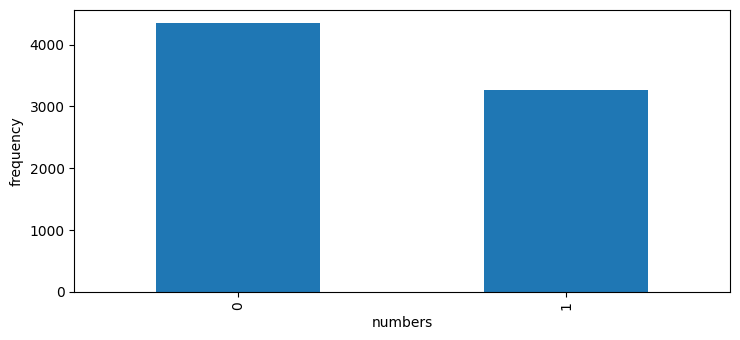

In [10]:
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

fig, ax = plt.subplots()

data['target'].value_counts().plot(ax=ax, kind='bar', xlabel='target', ylabel='frequency')

plt.show()

In [13]:
data.groupby('target').count()

,id,keyword,location,text
target,,,,
0,4342,4323,2884,4342
1,3271,3229,2196,3271


### Import BERT model and pre-processor

In [14]:
import tensorflow as tf
import tensorflow_hub as hub    
import tensorflow_text as text 

bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

### Build Model

In [15]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [17]:
# Metrics to be displayed
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

### Generate train and test set

In [18]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data["text"],data["target"], stratify=data["target"])

### Train Model

In [19]:
model.fit(x_train, y_train, epochs=10)

Epoch 1/10
179/179 [==============================] - 27s 108ms/step - loss: 0.6403 - accuracy: 0.6262 - precision: 0.5785 - recall: 0.4790
Epoch 2/10
179/179 [==============================] - 19s 107ms/step - loss: 0.5983 - accuracy: 0.6849 - precision: 0.6540 - recall: 0.5662
Epoch 3/10
179/179 [==============================] - 19s 107ms/step - loss: 0.5878 - accuracy: 0.6966 - precision: 0.6689 - recall: 0.5821
Epoch 4/10
179/179 [==============================] - 19s 106ms/step - loss: 0.5757 - accuracy: 0.7138 - precision: 0.6872 - recall: 0.6127
Epoch 5/10
179/179 [==============================] - 19s 106ms/step - loss: 0.5678 - accuracy: 0.7232 - precision: 0.7037 - recall: 0.6148
Epoch 6/10
179/179 [==============================] - 19s 106ms/step - loss: 0.5576 - accuracy: 0.7232 - precision: 0.7041 - recall: 0.6139
Epoch 7/10
179/179 [==============================] - 19s 107ms/step - loss: 0.5571 - accuracy: 0.7260 - precision: 0.7042 - recall: 0.6249
Epoch 8/10
179/179 [

### Evaluate Model

In [20]:
model.evaluate(x_test, y_test)

60/60 [==============================] - 7s 106ms/step - loss: 0.5084 - accuracy: 0.7715 - precision: 0.7812 - recall: 0.6504


[0.5084232091903687, 0.7715336084365845, 0.781204104423523, 0.6503667235374451]

In [21]:
y_predicted = model.predict(x_test)
y_predicted = y_predicted.flatten()

In [22]:
import numpy as np

# Thresholding for binary classification
y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 1, 0, ..., 1, 0, 1])

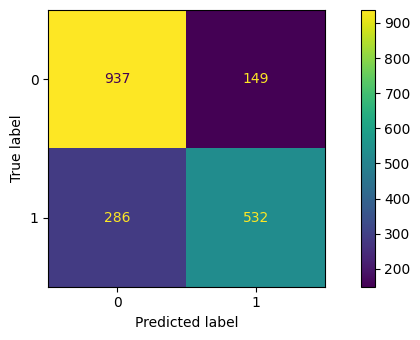

In [25]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_predicted)
ConfusionMatrixDisplay(cm).plot()

In [26]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.77      0.86      0.81      1086
           1       0.78      0.65      0.71       818

    accuracy                           0.77      1904
   macro avg       0.77      0.76      0.76      1904
weighted avg       0.77      0.77      0.77      1904

